# Result Statistics in CUNQA

Accessing intermediate quantum states and measurement statistics is essential when developing and validating quantum algorithms. Being able to inspect the full state evolution and extract flexible probability representations allows deeper debugging, subsystem analysis, and verification of simulation methods within CUNQA.

First we must start by importing the neccessary functions and deploying the needed vQPUs. Note that the instructions introduced in this notebook are supported only by Aer simulator as of now.

In [1]:
import os, sys
import numpy as np
import math

# In order to import cunqa, we append to the search path the cunqa installation path
sys.path.append(os.getenv("HOME")) # HOME as install path is specific to CESGA

from cunqa.circuit import CunqaCircuit
from cunqa.qpu import qraise, get_QPUs, run, qdrop

# Auxiliar functions to print statevectors, density matrices and probability distributions

def display_state(obj, decimals=6, tol=1e-12):
    arr = np.array(obj)

    # Remove singleton dimensions (e.g. (4,1) or (4,4,1))
    arr = np.squeeze(arr)

    # If it is a column vector, flatten it
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.flatten()

    # Remove very small numerical noise
    arr[np.abs(arr) < tol] = 0

    return np.round(arr, decimals)

def display_probabilities(probs, decimals=6, tol=1e-12):
    # Probabilities in the computational basis

    probs = np.array(probs).copy()
    probs[np.abs(probs) < tol] = 0
    probs = np.round(probs, decimals)

    num_qubits = int(math.log2(len(probs)))

    print("State  |  Probability")
    print("-" * 24)

    for i, p in enumerate(probs):
        bitstring = format(i, f"0{num_qubits}b")
        print(f"|{bitstring}>  |  {p}")


def display_per_qubit_probabilities(probs, decimals=6, tol=1e-12):
    probs = np.array(probs).copy()
    probs[np.abs(probs) < tol] = 0
    probs = np.round(probs, decimals)

    print("Qubit  |  P(0)     P(1)")
    print("-" * 28)
    for i, (p0, p1) in enumerate(probs):
        print(f"q{i}     |  {p0:<8} {p1}")


def display_partial_probabilities(probs, partial=None, decimals=6, tol=1e-12):

    print("State  |  Probability")
    print("-" * 24)

    for bitstring, p in probs.items():
        if abs(p) < tol:
            p = 0
        p = round(p, decimals)
        print(f"|{bitstring}>  |  {p}")

def display_partial_per_qubit_probabilities(probs, partial, decimals=6, tol=1e-12):
    probs = np.array(probs).copy()
    probs[np.abs(probs) < tol] = 0
    probs = np.round(probs, decimals)

    print(f"Qubit  |  P(0)     P(1)")
    print("-" * 28)
    for idx, (p0, p1) in zip(partial, probs):
        print(f"q{idx}     |  {p0:<8} {p1}")

family = qraise(3, "00:30:00", co_located = True) #Important: Aer simulator
qpus   = get_QPUs(co_located = True)

for qpu in qpus:
    print(f"\nQPU properties: \n\t id: {qpu.id}, backend: {qpu.backend['name']}, simulator: {qpu.backend['simulator']}, version: {qpu.backend['version']}.")

Requested QPUs with command:
	qraise -n 3 -t 00:30:00 --co-located
QPUs ready to work ✅

QPU properties: 
	 id: 379049_781905, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.

QPU properties: 
	 id: 379049_781906, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.

QPU properties: 
	 id: 379049_781907, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.


## Saving Quantum States

CUNQA allows saving the quantum state during circuit execution using `save_state()` method at `CunqaCircuit`. The object returned depends on the simulation method used at runtime. When executed with the statevector method, the saved object corresponds to the full statevector. When executed with the density matrix method, the returned object represents the density matrix of the system.

This enables inspecting the exact quantum state before measurement collapses it and allows comparing different physical simulation models without modifying the circuit definition.

We construct a simple test circuit to illustrate how states can be saved during execution:

In [2]:
circ = CunqaCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.rz(np.pi/4, 2)

# Saves the state. The state depends on the simulation method: it can be statevector, density matrix, ...
circ.save_state() 

circ.measure_all()

It is important so include such instruction **before** measurements so the state does not collapse to the computational basis and we can recover all the information in the other bases.

Now we execute the circuit with different simulation methods:

In [3]:
qjob_vec     = run(circ, qpus[-1], method="statevector")
qjob_densmat = run(circ, qpus[-2], method="density_matrix")

In [4]:
statevec = qjob_vec.result.statevector
densmat  = qjob_densmat.result.density_matrix

print(f"\nWe obtained the statevector \n{display_state(statevec)} \n\nand the density matrix \n{display_state(densmat)}")


We obtained the statevector 
[0.653281-0.270598j 0.      +0.j       0.      +0.j
 0.653281-0.270598j 0.      +0.j       0.      +0.j
 0.      +0.j       0.      +0.j      ] 

and the density matrix 
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


Here we see both results corresponding to the same state but different representation.

### Saving States at Multiple Points

CUNQA supports saving the state at multiple points within the same circuit. When more than one state is stored, each call to `save_state()` must include a unique label. If two saved states share the same label, an error will be raised.

Now we construct a circuit that prepares a Bell pair state and then applies additional unitaries to modify it. Both the prepared Bell pair and the final state are extracted.

In [5]:
circ_sev = CunqaCircuit(2)
circ.h(0)
circ.cx(0, 1)

# First save_state instructin
circ_sev.save_state(label="After Bell pair")

circ.rxx(np.pi/6, 0, 1)
circ.rz(np.pi/4, 0)

# Second save_state instruction
circ_sev.save_state(label="Final state")

circ_sev.measure_all()

Once again, they will be executed via both simulation methods:

In [6]:
qjob_vec_sev     = run(circ_sev, qpus[-1], method="statevector")
qjob_densmat_sev = run(circ_sev, qpus[-2], method="density_matrix")

When multiple states are saved, the result object returns a dictionary whose keys correspond to the provided labels and whose values correspond to the quantum states at those specific points in the circuit:

In [7]:
statevecs_dict = qjob_vec_sev.result.statevector
densmats_dict  = qjob_densmat_sev.result.density_matrix

print("\nStatevectors:")
for label, state in statevecs_dict.items():
    print(f"{label}:\n{display_state(state)}\n")

print("Density matrices:")
for label, state in densmats_dict.items():
    print(f"{label}:\n{display_state(state)}\n")



Statevectors:
After Bell pair:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]

Final state:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]

Density matrices:
After Bell pair:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

Final state:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]



This functionality is especially useful for analyzing intermediate entanglement, debugging circuit evolution, and studying the dynamics of parametrized or variational circuits.

## Extracting Probabilities

Probabilities can be extracted directly from the `Result` object of a `QJob`.

If a state has been saved during execution, probabilities are computed exactly from that state. Otherwise, probabilities are estimated from measurement counts obtained after sampling.

Let us compare the probabilities extracted on the three ways (from statevector, from density matrix or estimated from counts).

We recover the example used in the previous section but without the `save_state()` instruction:

In [8]:
circ_no_state = CunqaCircuit(3)

circ_no_state.h(0)
circ_no_state.cx(0, 1)
circ_no_state.rz(np.pi/4, 2)

circ_no_state.measure_all()

In [9]:
qjob_sampling = run(circ_no_state, qpus[-3])

Now we can compare its output with the ones obtained before:


Statevector probabilities:
State  |  Probability
------------------------
|000>  |  0.5
|001>  |  0.0
|010>  |  0.0
|011>  |  0.5
|100>  |  0.0
|101>  |  0.0
|110>  |  0.0
|111>  |  0.0

Density matrix probabilities:
State  |  Probability
------------------------
|000>  |  0.5
|001>  |  0.0
|010>  |  0.0
|011>  |  0.5
|100>  |  0.0
|101>  |  0.0
|110>  |  0.0
|111>  |  0.0

Sampling probabilities:
State  |  Probability
------------------------
|000>  |  0.475586
|001>  |  0.0
|010>  |  0.0
|011>  |  0.524414
|100>  |  0.0
|101>  |  0.0
|110>  |  0.0
|111>  |  0.0


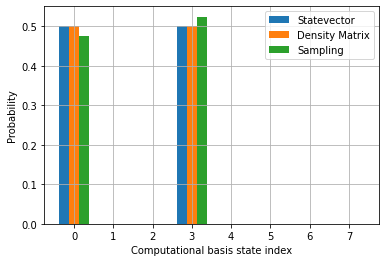

In [19]:
probs_vec      = qjob_vec.result.probabilities()
probs_densmat  = qjob_densmat.result.probabilities()
probs_sampling = qjob_sampling.result.probabilities()

print("\nStatevector probabilities:")
display_probabilities(probs_vec)

print("\nDensity matrix probabilities:")
display_probabilities(probs_densmat)

print("\nSampling probabilities:")
display_probabilities(probs_sampling)


import matplotlib.pyplot as plt
%matplotlib inline
n = len(probs_vec)
plt.figure()
plt.bar(np.arange(n) - 0.25, np.array(probs_vec), width=0.25, label="Statevector")
plt.bar(np.arange(n), np.array(probs_densmat), width=0.25, label="Density Matrix")
plt.bar(np.arange(n) + 0.25, np.array(probs_sampling), width=0.25, label="Sampling")

plt.grid(True)
plt.xlabel("Computational basis state index")
plt.ylabel("Probability")
plt.legend()

plt.show()


By default, probabilities correspond to full computational basis bitstrings and are ordered in ascending binary order. This makes it possible to directly compare exact probabilities obtained from the statevector or density matrix with sampling-based estimates.

### Per-Qubit Probabilities
Instead of full bitstring probabilities, it is often useful to compute marginal probabilities per qubit.

In this case, by setting `per_qubit = True` the output provides the probability of measuring `0` and `1` for each individual qubit. Correlations between qubits are not preserved in this representation, since each qubit is considered independently.

Per-qubit probabilities are useful for studying local observables, identifying bias or noise effects, and analyzing single-qubit behavior without focusing on global correlations.

In [11]:
print("\nPer qubit probabilities with statevector:")
display_per_qubit_probabilities(
    qjob_vec.result.probabilities(per_qubit=True)
)

print("\nPer qubit probabilities with density_matrix:")
display_per_qubit_probabilities(
    qjob_densmat.result.probabilities(per_qubit=True)
)

print("\nPer qubit probabilities with sampling:")
display_per_qubit_probabilities(
    qjob_sampling.result.probabilities(per_qubit=True)
)



Per qubit probabilities with statevector:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.5      0.5
q1     |  0.5      0.5
q2     |  1.0      0.0

Per qubit probabilities with density_matrix:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.5      0.5
q1     |  0.5      0.5
q2     |  1.0      0.0

Per qubit probabilities with sampling:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.475586 0.524414
q1     |  0.475586 0.524414
q2     |  1.0      0.0


### Partial Probabilities (Subsystem Marginalization)

In many circuits, not all qubits are relevant for the final observable. Ancilla qubits or auxiliary registers may be introduced temporarily and should not appear in the final statistics.

CUNQA allows marginalization over a selected subset of qubits. When using this option, bitstrings are reduced to the chosen indices, and the remaining qubits are marginalized out. The resulting probabilities correspond only to the subsystem of interest.

This provides a convenient way to discard ancillas, analyze subsystems, and extract reduced statistics from larger circuits.

In [13]:
print("\nPartial [0, 1] probabilities with statevector:")
display_partial_probabilities(
    qjob_vec.result.probabilities(partial=[0, 1]),
    partial=[0, 1]
)

print("\nPartial [0, 1] probabilities with density_matrix:")
display_partial_probabilities(
    qjob_densmat.result.probabilities(partial=[0, 1]),
    partial=[0, 1]
)

print("\nPartial [0, 1] probabilities with sampling:")
display_partial_probabilities(
    qjob_sampling.result.probabilities(partial=[0, 1]),
    partial=[0, 1]
)



Partial [0, 1] probabilities with statevector:
State  |  Probability
------------------------
|00>  |  0.5
|01>  |  0
|10>  |  0
|11>  |  0.5

Partial [0, 1] probabilities with density_matrix:
State  |  Probability
------------------------
|00>  |  0.5
|01>  |  0
|10>  |  0
|11>  |  0.5

Partial [0, 1] probabilities with sampling:
State  |  Probability
------------------------
|00>  |  0.475586
|01>  |  0
|10>  |  0
|11>  |  0.524414


### Combining Partial and Per-Qubit Options

Both marginalization over selected qubits and per-qubit probabilities can be combined. In this case, the output provides marginal single-qubit probabilities restricted to the chosen subset.

This allows flexible post-processing of measurement data and supports detailed subsystem analysis within CUNQA workflows.

In [16]:
print("\nPartial [0, 1] per qubit probabilities with statevector:")
display_partial_per_qubit_probabilities(
    qjob_vec.result.probabilities(per_qubit=True, partial=[0, 1]),
    partial=[0, 1]
)

print("\nPartial [0, 1] per qubit probabilities with density_matrix:")
display_partial_per_qubit_probabilities(
    qjob_densmat.result.probabilities(per_qubit=True, partial=[0, 1]),
    partial=[0, 1]
)

print("\nPartial [0, 1] per qubit probabilities with sampling:")
display_partial_per_qubit_probabilities(
    qjob_sampling.result.probabilities(per_qubit=True, partial=[0, 1]),
    partial=[0, 1]
)



Partial [0, 1] per qubit probabilities with statevector:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.5      0.5
q1     |  0.5      0.5

Partial [0, 1] per qubit probabilities with density_matrix:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.5      0.5
q1     |  0.5      0.5

Partial [0, 1] per qubit probabilities with sampling:
Qubit  |  P(0)     P(1)
----------------------------
q0     |  0.475586 0.524414
q1     |  0.475586 0.524414


We demonstrated how CUNQA allows saving quantum states at different stages of a circuit and retrieving them under different simulation methods. We also showed how to extract probabilities in flexible ways, including per bitstring, per qubit, and over selected subsets of qubits.

Finally, once execution is complete, `qdrop` must be called to properly release the allocated classical resources.

In [15]:
qdrop(family)

Removed job(s) with ID(s): 379049 
